In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import json
from pprint import pprint
import pandas as pd
from shapely.geometry import Polygon
import shapely
from sklearn import linear_model
import sklearn
from sklearn.preprocessing import PolynomialFeatures
%matplotlib widget

In [2]:
df = pd.read_csv(
    './data/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [3]:
cNames = [el for el in df]

In [4]:
years_names = cNames[12:4:-1]
years_names

['1970 Population',
 '1980 Population',
 '1990 Population',
 '2000 Population',
 '2010 Population',
 '2015 Population',
 '2020 Population',
 '2022 Population']

In [5]:
pops_ = np.zeros(shape=(len(df),len(years_names)))
for i in range(len(df)):
    pops_[i] = df.iloc[i][years_names].values

In [6]:
t_vec = np.asarray([float(el[:4]) for el in years_names])
print(t_vec)

[1970. 1980. 1990. 2000. 2010. 2015. 2020. 2022.]


In [7]:
total_N_per_year = np.zeros(shape=(len(t_vec),))
for i in range(len(t_vec)):
    total_N_per_year[i] = np.sum(pops_[:,i])
print(total_N_per_year)

[3.69413666e+09 4.44240037e+09 5.31419166e+09 6.14705570e+09
 6.98378500e+09 7.42480976e+09 7.83925060e+09 7.97341304e+09]


In [8]:
[el for el in zip(t_vec,total_N_per_year)]

[(1970.0, 3694136661.0),
 (1980.0, 4442400371.0),
 (1990.0, 5314191665.0),
 (2000.0, 6147055703.0),
 (2010.0, 6983784998.0),
 (2015.0, 7424809761.0),
 (2020.0, 7839250603.0),
 (2022.0, 7973413042.0)]

In [9]:
x_ = [[el] for el in t_vec]
x_

[[1970.0],
 [1980.0],
 [1990.0],
 [2000.0],
 [2010.0],
 [2015.0],
 [2020.0],
 [2022.0]]

In [10]:
y_ = [el for el in total_N_per_year]
y_

[3694136661.0,
 4442400371.0,
 5314191665.0,
 6147055703.0,
 6983784998.0,
 7424809761.0,
 7839250603.0,
 7973413042.0]

In [11]:
poly = PolynomialFeatures(degree=1, include_bias=False)
poly_features = poly.fit_transform(t_vec.reshape(-1, 1))

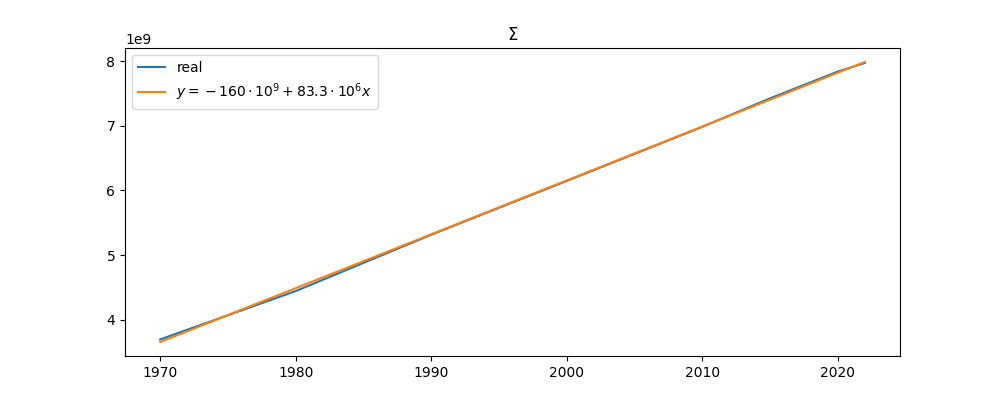

In [12]:
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.plot(t_vec,total_N_per_year,label='real')
ax.set_title(r'$\Sigma$')
C0 = 186*10**9
T0 = 2007.0
y_vec = C0/(T0-t_vec)
# ax.plot(t_vec, y_vec, label=r'$\frac{d}{dt}u = \frac{1}{C_0}u^2$')
# P_vec = 6.463/(1.0+11.926*np.exp(-0.097*(t_vec-1960.0)))*10**9
# ax.plot(t_vec, P_vec ,label =r'$sigma model$')
# ax.set_yscale('log')
reg = linear_model.Ridge(alpha=.5)
reg.fit(x_,y_)
lin_vec = reg.intercept_ + reg.coef_[0]*t_vec
ax.plot(t_vec, lin_vec ,label =r'$y={} \cdot 10^9 +{}\cdot 10^6 x$'.format(str(reg.intercept_/10**9)[:4],str(reg.coef_[0]/10**6)[:4]))
ax.legend()

Text(0.5, 1.0, 'per country')

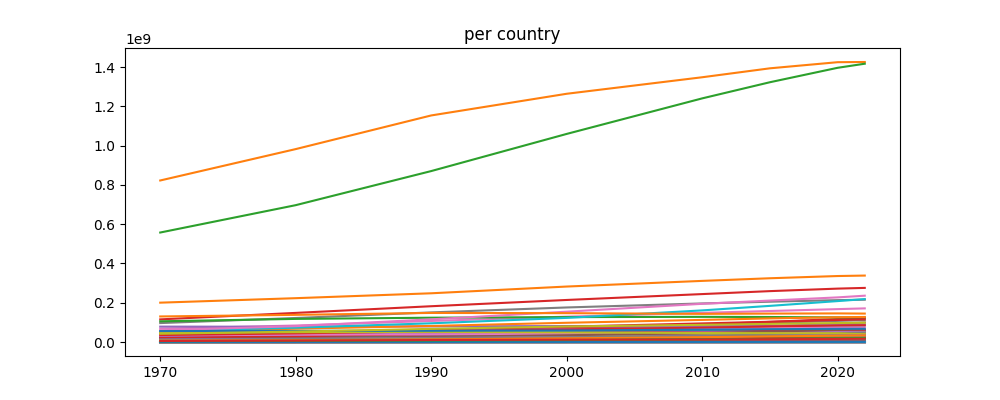

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
for i in range(len(pops_)):
    ax.plot(t_vec, pops_[i])
ax.set_title('per country')